This NoteBook Is Part of the Large Alterus Vera Assignment

<h1>Alternus Vera - Sy Le</h1>

Sy Le - 006088940

# Introduction


In this notebook, I will be covering 2 main topics  **context** (where the statements originate from) and **Social Reactions** (how the public react to these news), which combined can be a good collection of tools to identify fake news.

| Factor | Rationale |
| -- | -- | 
| Context  | Type  of the medium (e.g. Large media outlet vs. small blog) |


#### Motivations:
##### Context of a statement
The main reason why *context* is extremely important when it comes to identify the integrity of any statements is that certain medium like a TV ad which are could be fully sponsored by a particular party could potentially distort the integrity of a fact. TV Ads are not reliable because they are paid for to convey a message that potentially be beneficial to their sponsors. In this context, we should proceed with cautions.


#### Definitions:
##### Context
We will define `context` as a medium where the news is announced. So this could be a physical in person interview, or simply an online forum / social networks where the news occured


#### Dataset
##### Core Dataset
- **Politifact**: This is our core dataset. This contains statements, contexts along with the label whether the news is fake. This dataset can be downloaded at https://raw.githubusercontent.com/synle/machine-learning-sample-dataset/master/liar_dataset/test.tsv

##### Secondary Dataset used for data enrichment
- **Kaggle Liar:** This dataset is used for enrichment. This contains social reactions toward a particular statement. This dataset can be downloaded at https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv


### 1. what did you try?
First I did some experiments where I tried to find the correlation between context and label.

In this notebook, I tried to extract the meaning out of Context in which the news broke using nltk. Then I combine that context with the topics extracted from the statements using gensim and LDA along with the party affiliation. Finally I created a TFIDF matrix with these 3 features and combined them as my core features which then used by 2 classifiers: Logistic Regression and Random Forest to predict whether a news is a fake news


### 2. What worked?
#### Ngram=2
By combining TFIDF matrix of Context (using ngram=2) and the Statement values provided by politifact, I find that our classifier seems to be fairly reliable at deciding whether the news is fake.

#### `context + party + statement yields` good results
By combining the TFIDF matrix of context, party, and the statement, the result procuded are extremely reliable.



### 3. What did not work?
#### Stemming causes a lot of truncation
Although Stemming is fast, I find it transformed the words into unreadable sentences...

#### Loss of meaning using ngram=1
Initially when I tried to apply the classifier using ngram=1, the result is fairly skewed. During the transformation, I accidentally lose information provided by combination of word. For example, I couldn't conclude information for **Youtube Celebrity** in the context.

#### Loss of contextual data using just the context value alone
I found it hard to have a solid classifier based solely on **context**. When we omit the statements / topics made, we lose the context and correlation between the **context** and the **statement** made. For example, Fox News interviews might yield fake news label for non-republic data


### 4. what alternatives did you try?
#### Use ngram=2 for tfidf
As mentioned above, vectorizer of ngram=1 has lost some crucial information in classifiying the dataset. So I begin to experiment with higher value of ngram, namely ngram=2 or bigram tends to provide a more reliable result.

#### Use Lemmatization instead of Stemming
Use of Lemmatization preserves the words correctly compared with stemming


### 5. what did you research, what references (eg code) did you study or leverage (code)?
I researched on how to use TFIDF Vectorizer with nltk , and LDA with GenSim

#### Sources:
- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://github.com/FakeNewsChallenge
- https://datascience.stackexchange.com/questions/13120/how-to-overcome-training-examples-different-lengths-when-working-with-word-embe
- https://towardsdatascience.com/lda2vec-word-embeddings-in-topic-models-4ee3fc4b2843

### 6. what steps did you take as a team to find data enrichment sources, label data, feature engineering (e.g., nlp life cycle : stemming, lemmatization, spelling check, part of speech, classifications, naive bayes, decision tree, svm, td-idf , lda etc)?
In the team contribution, I spent most of my time working on stemming, lemmatization, tfidf classification with logistic regression

### Prerequisites:

Getting the dataset and downloading some key dependencies such as nltk, panda, etc...

In [0]:
%matplotlib inline


# dependencies
import pandas as pd
import nltk

# download nltk stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# gensim
! pip install gensim
! pip install spacy



# other imports
from gensim import corpora
import pickle
import pandas as pd
import io
import requests
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
    100% |████████████████████████████████| 23.6MB 1.4MB/s 
    100% |████████████████████████████████| 1.4MB 13.5MB/s 
    100% |████████████████████████████████| 133kB 28.8MB/s 
    100% |████████████████████████████████| 5.1MB 6.4MB/s 
    100% |████████████████████████████████| 61kB 22.2MB/s 
    100% |████████████████████████████████| 552kB 23.9MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    100% |████████████████████████████████| 13.9MB 2.

In [0]:
import pandas as pd
import io
import requests
import math

def get_parsed_data(url):
  return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep='\t', header=None)

def get_parsed_data2(url):
  return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')


columns_politifacts = [
  'id',
  'label',
  'statement',
  'subject',
  'speaker',
  'speakers_job_title',
  'state_info',
  'party_affiliation',
  'barely_true',
  'false',
  'half_true',
  'mostly_true',
  'pants_on_fire',
  'context',
]


# download and parse the dataset...
data_poli_test  = get_parsed_data('https://raw.githubusercontent.com/synle/machine-learning-sample-dataset/master/liar_dataset/test.tsv')
data_poli_train = get_parsed_data('https://raw.githubusercontent.com/synle/machine-learning-sample-dataset/master/liar_dataset/train.tsv')
data_poli_valid = get_parsed_data('https://raw.githubusercontent.com/synle/machine-learning-sample-dataset/master/liar_dataset/valid.tsv')
data_kg_fake_news = get_parsed_data2('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv')

# parsed the columns
data_poli_test.columns  = columns_politifacts
data_poli_train.columns = columns_politifacts
data_poli_valid.columns = columns_politifacts


#
data_to_use_for_test = data_poli_test
data_to_use_for_training = data_poli_train

#### Clean up the text with Stemming, Lemmatization, and Removal of Stopwords

Here we use stemmer and exclude words from english stop words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords


ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
english_stopwords = stopwords.words('english')

def split_text_into_tokens(text):
  tokens = re.split('\W+', text)
  return tokens


def clean_text_for_string(text):
  text = str(text)
  text = "".join([word.lower() for word in text])
  tokens = split_text_into_tokens(text)
#   Use Stemming
#   tokens = [ps.stem(word) for word in tokens if word not in english_stopwords]

#   Use Lemmatization
  lemmatize = [wn.lemmatize(word) for word in tokens if word not in english_stopwords]
  return " ".join(tokens).strip()


def routine_do_clean_context(current_df):
  # clean up text
  current_df['cleaned_context'] = current_df['context'].apply(clean_text_for_string)
  current_df['cleaned_statement'] = current_df['statement'].apply(clean_text_for_string)
  current_df['cleaned_party_affiliation'] = current_df['party_affiliation'].apply(clean_text_for_string)
  
  
routine_do_clean_context(data_to_use_for_training)
routine_do_clean_context(data_to_use_for_test)

In [0]:
# show output of the cleanup with the above lemmatization and cleanup
idx_to_print = 200
data_to_use_for_training['context'][idx_to_print], data_to_use_for_training['cleaned_context'][idx_to_print]

('a column published on NJ.com', 'a column published on nj com')

### Understanding the distribution of context and label

Here let's look at how the context relates to label and visualize the top context keyword. Below are how I construct the score of fake vs non fake

Given a label, and how each are score
- true: 1
- false: 0
- half-true: 0.5
- pants-fire: -1
- barely-true: 0.6
- mostly-true: 0.8

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def plot_dictionary_bar_chart(D, plot_title, constraint_min = -5, constraing_max = 40):
  # only plot the big keys...
  D = {k:v for (k,v) in D.items() if v > constraing_max or v < constraint_min}
  
  # make plot bigger
  figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
  
  # plot title
  plt.suptitle(plot_title, fontsize=16)

  
  # plot
  plt.bar(range(len(D)), list(D.values()), align='center')
  plt.xticks(range(len(D)), list(D.keys()))
  plt.show()


def get_label_score_from_string(current_label):
  if current_label == 'true':
    return 1
  if current_label == 'false':
    return 0
  if current_label == 'half-true':
    return 0.5
  if current_label == 'pants-fire':
    return -1
  if current_label == 'barely-true':
    return 0.6
  if current_label == 'mostly-true':
    return 0.8
  return 0


def get_stats_for_context_from_data_frame(current_df):
  stats_context_general_score = {}
  stats_context_agg_score = {}
  
  for current_row_tuple in current_df.iterrows():
    current_row = current_row_tuple[1]
    current_row_label = current_row['label']
    topic_context = current_row['cleaned_context']

    if topic_context not in stats_context_general_score.keys():
      stats_context_general_score[topic_context] = {
        'true': 0,
        'false': 0,
        'half-true': 0,
        'pants-fire': 0,
        'barely-true': 0,
        'mostly-true': 0
      }

    stats_context_general_score[topic_context][current_row_label] = stats_context_general_score[topic_context][current_row_label] + 1

    if topic_context not in stats_context_agg_score.keys():
      stats_context_agg_score[topic_context] = 0

    stats_context_agg_score[topic_context] = get_label_score_from_string(current_row_label) + stats_context_agg_score[topic_context]

  #
  return stats_context_general_score, stats_context_agg_score

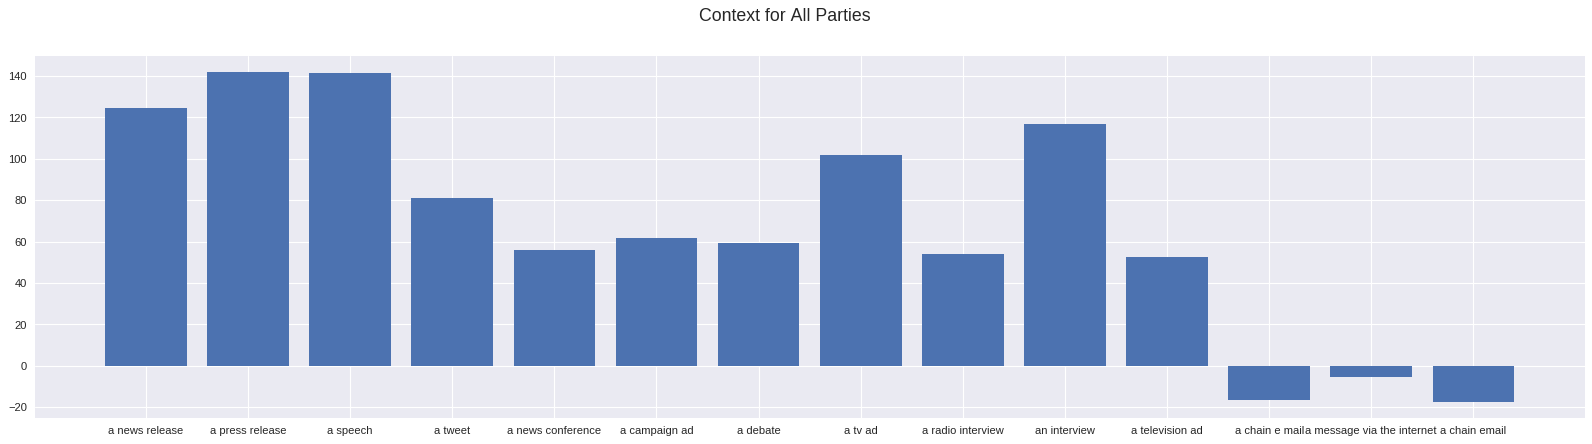

In [0]:
stats_context_general_score, stats_context_agg_score = get_stats_for_context_from_data_frame(data_to_use_for_training)
plot_dictionary_bar_chart(stats_context_agg_score, 'Context for All Parties')


In [0]:
print(stats_context_agg_score)

{'a mailer': 1.7000000000000002, 'a floor speech': 6.199999999999999, 'denver': 8.0, 'a news release': 124.69999999999976, 'an interview on cnn': 12.1, 'a an online opinion piece': 1, 'a press release': 141.79999999999987, 'a democratic debate in philadelphia pa': 1.8, 'a website': 8.5, 'an online video': 5.199999999999999, 'a speech': 141.29999999999987, 'a tweet': 81.1999999999999, 'an interview with cbn news': 0, 'a doonesbury strip in the sunday comics': 0.8, 'comments on fox news sunday': 12.700000000000001, 'a town hall in austin texas': 0.5, 'a radio ad': 22.700000000000006, 'a congressional hearing': 3.4000000000000004, 'an interview with bloomberg news': 0.8, 'a campaign debate': 2.8, 'a discussion on fox news the five': 1.8, 'remarks at a kentucky rally': 0.8, 'a campaign tv ad': 11.600000000000001, 'a news conference': 55.89999999999999, 'a speech after a terrorist attack in orlando': 0.8, 'an oped column': 3.9, 'a gubernatorial debate': 1.3, 'a radio talk show': 2.6, 'a cam

(array([ 3., 22., 15.,  4.,  5.,  1.,  1.,  1.,  1.]),
 array([-20.        ,  -2.22222222,  15.55555556,  33.33333333,
         51.11111111,  68.88888889,  86.66666667, 104.44444444,
        122.22222222, 140.        ]),
 <a list of 9 Patch objects>)

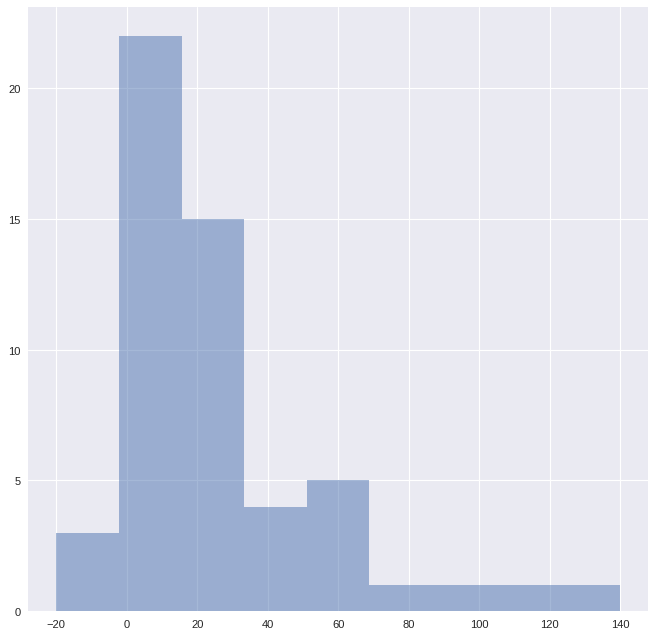

In [0]:
import numpy as np
import matplotlib.pyplot as plt
bins = np.linspace(-20, 140, 10)
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')


bucket_values = []
for value in stats_context_agg_score.values():
  if value > 10 or value < -4:
    bucket_values.append(value)

plt.hist(bucket_values, bins, alpha=0.5)


### Let's rerun the experiment grouped by the 

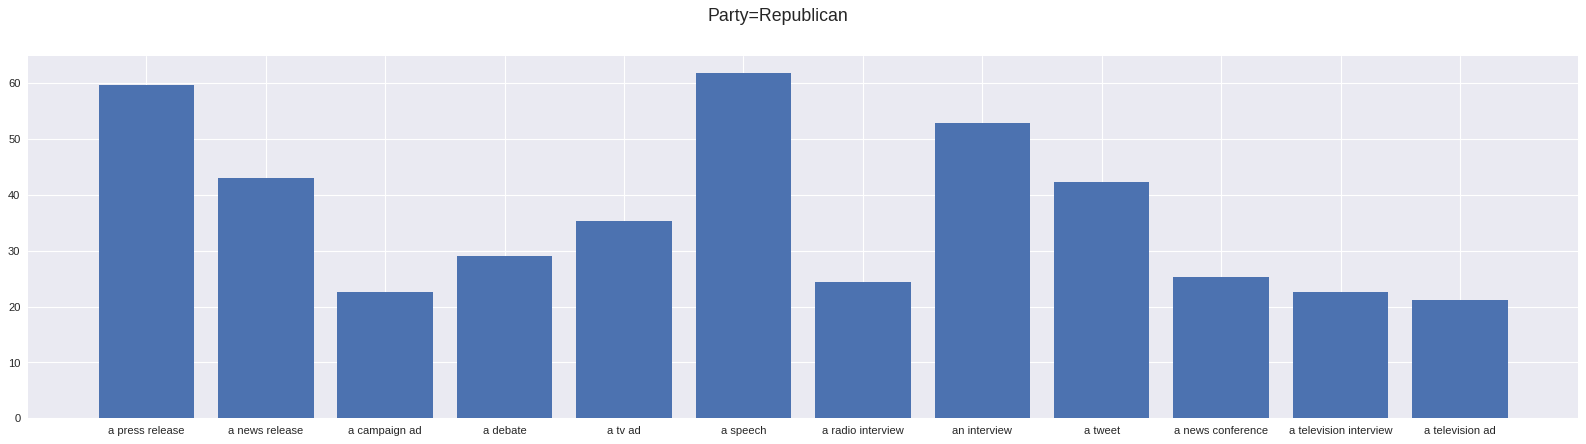

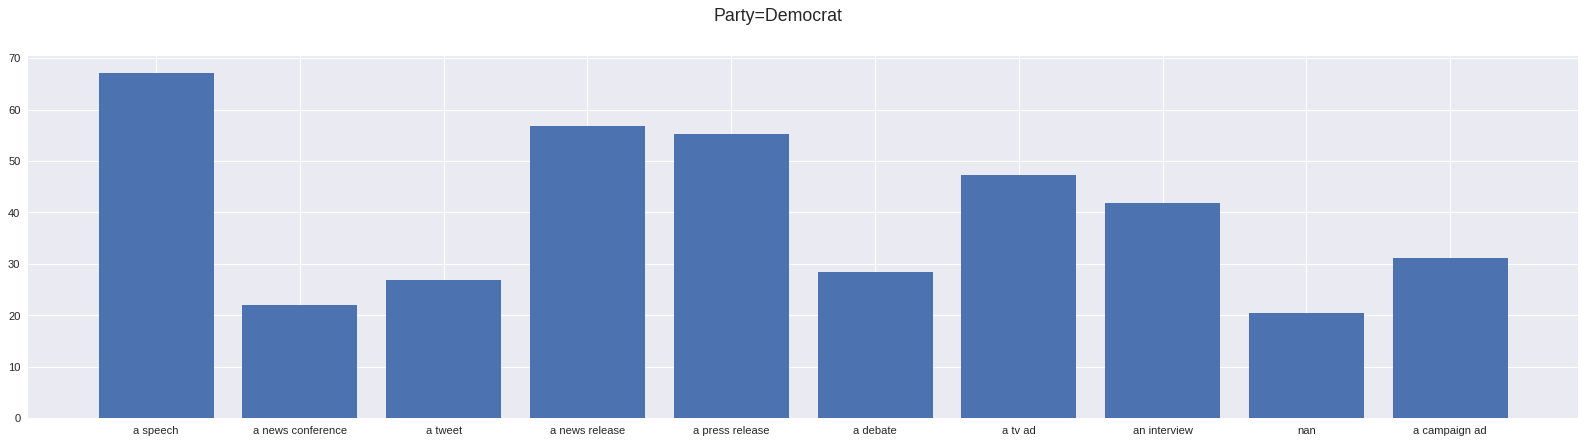

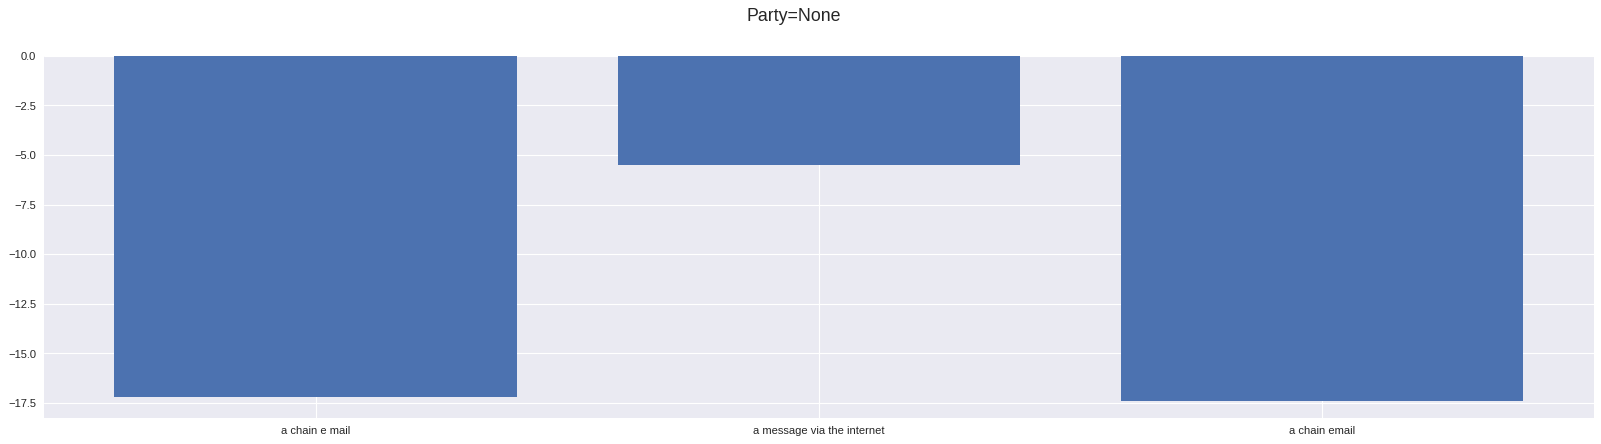

In [0]:
stats_context_general_score_republican, stats_context_agg_score_republican = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'republican'])
plot_dictionary_bar_chart(stats_context_agg_score_republican, 'Party=Republican', -3, 20)
stats_context_general_score_democrat, stats_context_agg_score_democrat = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'democrat'])
plot_dictionary_bar_chart(stats_context_agg_score_democrat, 'Party=Democrat', -3, 20)
stats_context_general_score_none, stats_context_agg_score_none = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'none'])
plot_dictionary_bar_chart(stats_context_agg_score_none, 'Party=None', -3, 20)
# stats_context_general_score_organization, stats_context_agg_score_organization = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'organization'])
# plot_dictionary_bar_chart(stats_context_agg_score_organization, 'Party=Organization', -3, 30)
# stats_context_general_score_independent, stats_context_agg_score_independent = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'independent'])
# plot_dictionary_bar_chart(stats_context_agg_score_independent, 'Party=Independent', -3, 30)
# stats_context_general_score_columnist, stats_context_agg_score_columnist = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'columnist'])
# plot_dictionary_bar_chart(stats_context_agg_score_columnist, 'Party=Columnist', -3, 30)
# stats_context_general_score_activist, stats_context_agg_score_activist = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'activist'])
# plot_dictionary_bar_chart(stats_context_agg_score_activist, 'Party=Activist', -3, 30)
# stats_context_general_score_talk_show_host, stats_context_agg_score_talk_show_host = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'talk-show-host'])
# plot_dictionary_bar_chart(stats_context_agg_score_talk_show_host, 'Party=Talk-show-host', -3, 30)
# stats_context_general_score_libertarian, stats_context_agg_score_libertarian = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'libertarian'])
# plot_dictionary_bar_chart(stats_context_agg_score_libertarian, 'Party=Libertarian', -3, 30)
# stats_context_general_score_newsmaker, stats_context_agg_score_newsmaker = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'newsmaker'])
# plot_dictionary_bar_chart(stats_context_agg_score_newsmaker, 'Party=Newsmaker', -3, 30)
# stats_context_general_score_journalist, stats_context_agg_score_journalist = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'journalist'])
# plot_dictionary_bar_chart(stats_context_agg_score_journalist, 'Party=Journalist', -3, 30)
# stats_context_general_score_labor_leader, stats_context_agg_score_labor_leader = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'labor-leader'])
# plot_dictionary_bar_chart(stats_context_agg_score_labor_leader, 'Party=Labor-leader', -3, 30)
# stats_context_general_score_state_official, stats_context_agg_score_state_official = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'state-official'])
# plot_dictionary_bar_chart(stats_context_agg_score_state_official, 'Party=State-official', -3, 30)
# stats_context_general_score_business_leader, stats_context_agg_score_business_leader = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'business-leader'])
# plot_dictionary_bar_chart(stats_context_agg_score_business_leader, 'Party=Business-leader', -3, 30)
# stats_context_general_score_education_official, stats_context_agg_score_education_official = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'education-official'])
# plot_dictionary_bar_chart(stats_context_agg_score_education_official, 'Party=Education-official', -3, 30)
# stats_context_general_score_tea_party_member, stats_context_agg_score_tea_party_member = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'tea-party-member'])
# plot_dictionary_bar_chart(stats_context_agg_score_tea_party_member, 'Party=Tea-party-member', -3, 30)
# stats_context_general_score_green, stats_context_agg_score_green = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'green'])
# plot_dictionary_bar_chart(stats_context_agg_score_green, 'Party=Green', -3, 30)
# stats_context_general_score_liberal_party_canada, stats_context_agg_score_liberal_party_canada = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'liberal-party-canada'])
# plot_dictionary_bar_chart(stats_context_agg_score_liberal_party_canada, 'Party=Liberal-party-canada', -3, 30)
# stats_context_general_score_government_body, stats_context_agg_score_government_body = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'government-body'])
# plot_dictionary_bar_chart(stats_context_agg_score_government_body, 'Party=Government-body', -3, 30)
# stats_context_general_score_moderate, stats_context_agg_score_moderate = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'Moderate'])
# plot_dictionary_bar_chart(stats_context_agg_score_moderate, 'Party=Moderate', -3, 30)
# stats_context_general_score_democratic_farmer_labor, stats_context_agg_score_democratic_farmer_labor = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'democratic-farmer-labor'])
# plot_dictionary_bar_chart(stats_context_agg_score_democratic_farmer_labor, 'Party=Democratic-farmer-labor', -3, 30)
# stats_context_general_score_ocean_state_tea_party_action, stats_context_agg_score_ocean_state_tea_party_action = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'ocean-state-tea-party-action'])
# plot_dictionary_bar_chart(stats_context_agg_score, 'stats_context_agg_score_ocean_state_tea_party_action=Ocean-state-tea-party-action', -3, 30)
# stats_context_general_score_constitution_party, stats_context_agg_score_constitution_party = get_stats_for_context_from_data_frame(data_to_use_for_training[data_to_use_for_training['party_affiliation'] == 'constitution-party'])
# plot_dictionary_bar_chart(stats_context_agg_score_constitution_party, 'Party=Constitution-party', -3, 30)

### Basic conclusion from the above context analysis...

As we can see, `a chain email` or `a message from the internet` tends to have an extremely low score and likely to be concluded as fake news.

On the other hand, `a press release` and `a speech` tend to provide a better integrity and authenticity of the news.

### Using LDA with gensim to extract topics from the statement

In [0]:
from gensim import corpora
import pickle
import gensim

def parseTopics(topics):
   return parseTopicsFromText(topics[0][1])


def parseTopicsFromText(text):
   output = []
   words = text.split( '+' )
   for word in words:
      output.append( word.split('*')[1].replace( '"', '' ).strip() )
   return output


def get_topics_from_tokenizer(text_data_column, num_topics):
  text_data = [text_data_column]

  # get the dictionary from our text_data
  dictionary = corpora.Dictionary(text_data)
  corpus = [dictionary.doc2bow(text) for text in text_data]
  
  if len(dictionary) == 0:
    return []
  
  # get the topics
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=4)
  topics = ldamodel.print_topics(num_words=4)
  return " ".join(parseTopics(topics))

# Let's grab the text_data
def get_topics(current_df, colFrom, colTo, num_topics):  
  current_df[colTo] = current_df[colFrom].apply(lambda x: get_topics_from_tokenizer(split_text_into_tokens(x), num_topics))
  
####
get_topics(data_to_use_for_training, colFrom='cleaned_statement', colTo='topics_statements', num_topics=4)
get_topics(data_to_use_for_test, colFrom='cleaned_statement', colTo='topics_statements', num_topics=4)

A quick look at the topic extracted from statement using `gensim` and `LDA`.

In [0]:
idx_to_print = 200
data_to_use_for_training['cleaned_statement'][idx_to_print], data_to_use_for_training['topics_statements'][idx_to_print]

('point pleasant beach does not own its beaches they are privately owned and operated by businesses such as jenkinsons',
 'and not they beach')

In [0]:
# parse stuff with spacy
def get_context_score_reliability(text):
  clean_context = clean_text_for_string(text)
  
  # Group a: score of 2.5
  group_a = [
    'press release',
    'speech',
    'news release',
    'interview'
  ]

  # Group b: score 1.2
  group_b = [
    'news conference',
    'debate',
    'tv ad',
    'television ad',
    'radio interview',
    'tweet',
    'town hall'
  ]

  # Group c: score of 0.7
  group_c = [
    'email',
    'e-mail',
    'e mail',
    'message via the internet'
    'democratic'
  ]

  
  # Group d: score of 0.5
  group_d = [
    'fox',
    'cbs',
    'cbn',
    'stephen colbert',
    'abc news',
    'msnbc',
    'nbc',
    'new york times'
  ]

  score = 0


  for phrase in group_a:
    if phrase in clean_context:
      score = score + 2.5


  for phrase in group_b:
    if phrase in clean_context:
      score = score + 1.2


  for phrase in group_c:
    if phrase in clean_context:
      score = score + 0.7
      
      
  for phrase in group_d:
    if phrase in clean_context:
      score = score + 0.5


  if score > 10.0:
    score = 10


  if score == 0:
    score = len(split_text_into_tokens(clean_context))
    if score > 3:
      score = 3
    

  return score


data_to_use_for_training['score_context_reliability'] = data_to_use_for_training['context'].apply(get_context_score_reliability)
data_to_use_for_test['score_context_reliability']     = data_to_use_for_test['context'].apply(get_context_score_reliability)

#### Applying TDIDF Vectorizer

Here we use stemmer and exclude words from english stop words **TDIDF Vectorizer with NGram = 2**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def calculate_tdif_context(current_df):
#   return calculate_tdif_context_count_vect(current_df)
#   return calculate_tdif_context_tfidf(current_df)
  return calculate_tdif_context_tfidf_2(current_df)


def calculate_tdif_context_count_vect(current_df):
  ####
  count_vect_context = CountVectorizer(ngram_range=(2,2))
  count_vect_statement = CountVectorizer(ngram_range=(1,2))
  count_vect_party_affiliation = CountVectorizer(ngram_range=(1,2))

  X_count_vect_context = count_vect_context.fit_transform(current_df['cleaned_context'])
  X_count_vect_statement = count_vect_statement.fit_transform(current_df['topics_statements'])
  X_count_vect_party_affiliation = count_vect_party_affiliation.fit_transform(current_df['cleaned_party_affiliation'])

  X_count_vect_context = pd.DataFrame(X_count_vect_context.toarray())
  X_count_vect_context.columns = count_vect_context.get_feature_names()
  X_count_vect_statement = pd.DataFrame(X_count_vect_statement.toarray())
  X_count_vect_statement.columns = count_vect_statement.get_feature_names()
  X_count_vect_party_affiliation = pd.DataFrame(X_count_vect_party_affiliation.toarray())
  X_count_vect_party_affiliation.columns = count_vect_party_affiliation.get_feature_names()
  
  return pd.concat([X_count_vect_party_affiliation, X_count_vect_context, X_count_vect_statement], axis=1), X_count_vect_party_affiliation.head(1), X_count_vect_context.head(1), X_count_vect_statement.head(1)



def calculate_tdif_context_tfidf(current_df):
  ####
  tfidf_vect_context = TfidfVectorizer(ngram_range=(2,2))
  tfidf_vect_statement = TfidfVectorizer(ngram_range=(1,2))
  tfidf_vect_party_affiliation = TfidfVectorizer(ngram_range=(1,2))

  X_tfidf_context = tfidf_vect_context.fit_transform(current_df['cleaned_context'])
  X_tfidf_statement = tfidf_vect_statement.fit_transform(current_df['topics_statements'])
  X_tfidf_party_affiliation = tfidf_vect_party_affiliation.fit_transform(current_df['cleaned_party_affiliation'])
  X_df_tfidf_context = pd.DataFrame(X_tfidf_context.toarray())
  X_df_tfidf_context.columns = tfidf_vect_context.get_feature_names()
  X_df_tfidf_statement = pd.DataFrame(X_tfidf_statement.toarray())
  X_df_tfidf_statement.columns = tfidf_vect_statement.get_feature_names()
  X_df_tfidf_party_affiliation = pd.DataFrame(X_tfidf_party_affiliation.toarray())
  X_df_tfidf_party_affiliation.columns = tfidf_vect_party_affiliation.get_feature_names()

  #
  return pd.concat([X_df_tfidf_party_affiliation, X_df_tfidf_context, X_df_tfidf_statement], axis=1), X_df_tfidf_context.head(1), X_df_tfidf_statement.head(1), X_df_tfidf_party_affiliation.head(1)



def calculate_tdif_context_tfidf_2(current_df):
  ####
  tfidf_vect_context = TfidfVectorizer(ngram_range=(2,2))
  tfidf_vect_statement = TfidfVectorizer(ngram_range=(1,2))
  tfidf_vect_party_affiliation = TfidfVectorizer(ngram_range=(1,2))

  X_tfidf_context = tfidf_vect_context.fit_transform(current_df['cleaned_context'])
  X_tfidf_statement = tfidf_vect_statement.fit_transform(current_df['topics_statements'])
  X_tfidf_party_affiliation = tfidf_vect_party_affiliation.fit_transform(current_df['cleaned_party_affiliation'])
  X_df_tfidf_context = pd.DataFrame(X_tfidf_context.toarray())
  X_df_tfidf_context.columns = tfidf_vect_context.get_feature_names()
  X_df_tfidf_statement = pd.DataFrame(X_tfidf_statement.toarray())
  X_df_tfidf_statement.columns = tfidf_vect_statement.get_feature_names()
  X_df_tfidf_party_affiliation = pd.DataFrame(X_tfidf_party_affiliation.toarray())
  X_df_tfidf_party_affiliation.columns = tfidf_vect_party_affiliation.get_feature_names()

  #
  return pd.concat([current_df['score_context_reliability'], X_df_tfidf_party_affiliation, X_df_tfidf_statement], axis=1), X_df_tfidf_context.head(1), X_df_tfidf_statement.head(1), X_df_tfidf_party_affiliation.head(1)


In [0]:
X_train, X_df_tfidf_context_head, X_df_tfidf_statement_head, X_df_tfidf_party_affiliation_head = calculate_tdif_context(data_to_use_for_training)
X_test = calculate_tdif_context(data_to_use_for_test)

##### Visualizing the vectorizer

In [0]:
X_df_tfidf_context_head

,10 against,10 news,10 years,101 ask,101 fm,10th house,1104 in,12 debate,12 near,12 new,...,your favorite,youtube ad,youtube and,youtube attack,youtube campaign,youtube com,youtube debate,youtube video,zach galifianakis,zakaria gps
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_df_tfidf_statement_head

,000,000 100,000 119,000 134,000 15,000 1789,000 20,000 2010,000 235,000 36,...,zika,zika critical,zika initially,zika is,zip,zombies,zone,zone cut,zuckerbergs,zuckerbergs marco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_df_tfidf_party_affiliation_head

,action,activist,body,business,business leader,canada,columnist,constitution,constitution party,democrat,...,republican,show,show host,state,state official,state tea,talk,talk show,tea,tea party
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Coming up with the matrix for classification


```
Resulting Matrix  = Context Reliability + Party TFIDF Matrix + Statement LDA Topics TFIDF Matrix
```

In [0]:
X_train.head(1)

,score_context_reliability,action,activist,body,business,business leader,canada,columnist,constitution,constitution party,...,zika,zika critical,zika initially,zika is,zip,zombies,zone,zone cut,zuckerbergs,zuckerbergs marco
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's do classifier with Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


LogReg = LogisticRegression()
Y_train = data_to_use_for_training['label']
Y_test = data_to_use_for_test['label']
LogReg_model = LogReg.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Let's do classifier with Random Forest

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RForest = RandomForestClassifier(n_estimators=50, max_depth=50, n_jobs=-1)
RForest_model = RForest.fit(X_train, Y_train)

### Moment of truth: the accuracy of our Logistic Classifer

In [0]:
print('Logistic Regression Score:')
print(LogReg.score(X_train, Y_train))


print('Random Forest Score:')
print(RForest.score(X_train, Y_train))

Logistic Regression Score:
0.81826171875
Random Forest Score:
0.56416015625


In [0]:
# LogReg2 = LogisticRegression()
# X_train_2 = data_to_use_for_training['score_context_reliability'].values
# X_test_2 = data_to_use_for_test['score_context_reliability']
# LogReg_model2 = LogReg2.fit(X_train, Y_train)

In [0]:
# print('Logistic Regression Score:')
# print(LogReg2.score(X_train_2, Y_train))

As seen on the above, the score from Logistic Regression score is much higher than Random Forest

## Generate the score for Reliability Score and Social Score

The following section will discover the reliabilty score and social score

### Generate the CSV for factor score in term of news reliability

In [0]:
# dependencies
import pandas as pd
import nltk
import numpy as np
import io
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from string import punctuation
from nltk import PorterStemmer
import copy 
import re, math
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
from nltk import bigrams
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.ldamodel import LdaModel
from gensim.models import Word2Vec, Doc2Vec
from gensim.corpora import Dictionary
import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# data_kg_fake_news.head(3)
# data_kg_fake_news.site_url.unique()
data_kg_fake_news.domain_rank.unique()

array([25689.,    nan, 65078., 18533., 37161.,  5772., 78393., 25842.,
        3734., 94243., 42160., 12993., 48959., 61606.,  6659.,  7587.,
       93026.,   967., 16425., 22665., 10352., 87365.,   486., 23950.,
       39980., 36674., 15846., 60570., 11584., 77628., 22680., 25709.,
         553., 48175., 35381., 32069., 40299., 40480., 34811., 19116.,
       12387., 70635., 51784., 56000., 78345., 60463., 17592., 67400.,
       65917., 82758.,  2774., 68648., 32398., 79662., 53149., 44479.,
       26413., 30230., 23040., 21114., 68691., 98679., 54210.,  6416.,
       88660., 43327., 27046., 23349., 10414., 61423., 91187.,  4617.,
       12191., 75353., 38347., 18495., 41475., 17423., 22432., 44451.,
       16994., 57497., 28149., 25945.,   538., 31016., 63847., 62759.,
       22891., 91245.,  1616., 96853., 18896., 91878., 33221., 63072.,
       56487., 65975., 65060.,  8968., 18369., 93150.,  2182., 19375.,
       42575., 37614.,  9645., 14958., 30890., 84363., 24453., 49688.,
      

In [0]:
def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')
  
def tokenize2(text):
    cachedStopWords = set(stopwords.words('english') + list(punctuation))
    min_length = 3
    # tokenize
    # convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stop words
    words = [word for word in words if word not in cachedStopWords]
    # steming
    tokens = list(map(lambda token: PorterStemmer().stem(token), words))
    # lemmatize
    lemmas = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    # only focus on alphabetic words
    p = re.compile('[a-zA-Z]+')
    
    filtered_lemmas = list(filter(lambda lemma: p.match(lemma) and len(lemma) >= min_length, lemmas))
    return filtered_lemmas

In [0]:
from nltk.corpus import stopwords


# download and parse the dataset...
data_kg_fake_news    = get_parsed_data2('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv')
data_kg_nonfake_news = get_parsed_data2('https://dock2.hyunwookshin.com/public/cmpe257_a1/articles1.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
data_kg_fake_news.loc[data_kg_fake_news['type']!='bs', 'type'] = 0
data_kg_fake_news.loc[data_kg_fake_news['type']=='bs', 'type'] = 1

In [0]:
data_kg_nonfake_news.rename(columns={"content": "text"}, inplace=True)
data_kg_nonfake_news['type'] = 0
data_kg_nonfake_news['spam_score'] = 0
data_kg_nonfake_news['domain_rank'] = None
data_kg_nonfake_news['participants_count'] = 0
data_kg_nonfake_news['likes'] = 0
data_kg_nonfake_news['shares'] = 0
data_kg_nonfake_news['comments'] = 0
data_kg_nonfake_news['replies_count'] = 0

In [0]:
all_data = pd.concat([data_kg_fake_news[['spam_score','domain_rank','participants_count','likes','shares','comments','replies_count','type']], data_kg_nonfake_news[['spam_score','domain_rank','participants_count','likes','shares','comments','replies_count','type']]])

In [0]:
all_data.head(3)

,spam_score,domain_rank,participants_count,likes,shares,comments,replies_count,type
0,0.0,25689.0,1,0,0,0,0,0
1,0.0,25689.0,1,0,0,0,0,0
2,0.0,25689.0,1,0,0,0,0,0


In [0]:
data_kg_nonfake_news.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,text,type
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,0
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",0
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",0
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",0
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",0


In [0]:
data_kg_fake_news.head(2)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,0


In [0]:
from google.colab import files

all_datap[].to_csv('df.csv')
files.download('df.csv')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def get_reputation_score(value):
  new_reputation_value = 0
  if not math.isnan(value):
    new_reputation_value = math.floor(value / 10000)
    if( new_reputation_value > 10 ):
      new_reputation_value = 10
    new_reputation_value = 10 - new_reputation_value
  return new_reputation_value

  
bucket_reputation_scores = []
for value in data_kg_fake_news.domain_rank:
  new_reputation_value = get_reputation_score(value)
  bucket_reputation_scores.append(new_reputation_value)

reputation score


(array([4718.,  307.,  310., 1246.,  540.,  764., 1250., 1092., 2772.]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]),
 <a list of 9 Patch objects>)

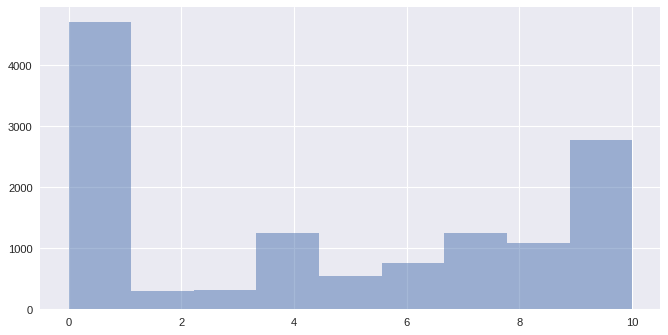

In [0]:
print('reputation score')
bins = np.linspace(0, 10, 10)
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.hist(bucket_reputation_scores, bins, alpha=0.5)


spam score


(array([4718.,  307.,  310., 1246.,  540.,  764., 1250., 1092., 2772.]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]),
 <a list of 9 Patch objects>)

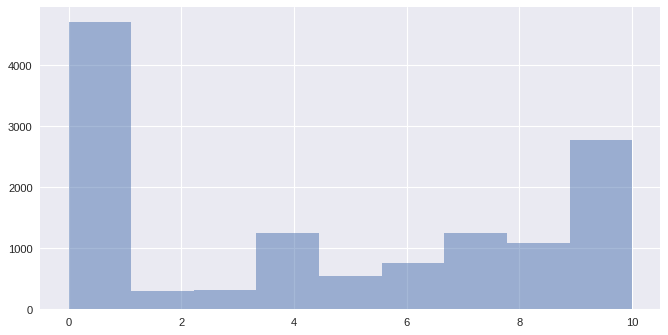

In [0]:
def get_spam_score(value):
  new_spam_score = 0
  if not math.isnan(value):
    new_spam_score = value * 10
    if( new_spam_score > 10 ):
      new_spam_score = 10
  return new_spam_score


bucket_reliability_score = []
for value in data_kg_fake_news.spam_score:
  new_reputation_value = get_reputation_score(value)
  bucket_reliability_score.append(new_reputation_value)
  
  
print('spam score')
bins = np.linspace(0, 10, 10)
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.hist(bucket_reputation_scores, bins, alpha=0.5)


In [0]:
# data_kg_fake_news.participants_count.unique() # 300
# data_kg_fake_news.likes.unique() # 1000
# data_kg_fake_news.shares.unique() # 1000

In [0]:
def get_social_activity_score(row):
  new_social_score = 0
  
  if(row['participants_count'] > 0):
    new_social_score = new_social_score +  0.33 * (row['participants_count'] / 300)
    
  if(row['likes'] > 0):
    new_social_score = new_social_score +  0.33 * (row['likes'] / 300)
    
  if(row['shares'] > 0):
    new_social_score = new_social_score +  0.33 * (row['shares'] / 300)
  
  if( new_social_score > 10 ):
    new_social_score = 10
    
  return new_social_score * 10



all_data['calculated_social_score'] = all_data.apply(lambda row: get_social_activity_score(row), axis=1)


In [0]:
all_data['calculated_reputation_score'] = all_data['domain_rank'].apply(get_reputation_score)
all_data['calculated_spam_score'] = all_data['spam_score'].apply(get_spam_score)


In [0]:
all_data.head(10)

,spam_score,domain_rank,participants_count,likes,shares,comments,replies_count,type,calculated_reputation_score,calculated_spam_score,calculated_social_score
0,0.000,25689.0,1,0,0,0,0,0,8,0.00,0.011
1,0.000,25689.0,1,0,0,0,0,0,8,0.00,0.011
2,0.000,25689.0,1,0,0,0,0,0,8,0.00,0.011
3,0.068,25689.0,0,0,0,0,0,0,8,0.68,0.000
4,0.865,25689.0,0,0,0,0,0,0,8,8.65,0.000
5,0.000,25689.0,1,0,0,0,0,0,8,0.00,0.011
6,0.701,25689.0,0,0,0,0,0,0,8,7.01,0.000
7,0.188,25689.0,0,0,0,0,0,0,8,1.88,0.000
8,0.144,25689.0,0,0,0,0,0,0,8,1.44,0.000
9,0.995,25689.0,0,0,0,0,0,0,8,9.95,0.000


In [0]:
# download as CSV
from google.colab import files

all_data[['type', 'calculated_reputation_score', 'calculated_spam_score', 'calculated_social_score']].to_csv('factor_social_reliablity.csv')
files.download('factor_social_reliablity.csv')